In [1]:
import os
import jax.numpy as jnp
from jax import random
from linear_model import LinearMonetaryModel
import matplotlib.pyplot as plt
from config import benchmark_dict, result_path

result_dir = os.path.join(result_path, 'linear_model')
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

ModuleNotFoundError: No module named 'jax'

### Q1

In [ ]:
def get_simulated_series(model, P, T, prev_shock, params=3):
    """
    Simulate the path of economic parameters from the model.

    Args:
        model: The monetary model to simulate.
        P: The transition matrix.
        T: The number of time steps to simulate.
        prev_shock: The initial shock state.
        params: The number of eco parameters in the model.
        
    Returns:
        A tuple containing the simulated measurement series.
    """
    shock_series = []
    measurement_series = []

    key = random.PRNGKey(0)
    shock_matrix = random.normal(key, shape=(T, params))

    for t in range(T):
        current_shock = model.transition(prev_shock, shock_override=shock_matrix[t])
        measurement = model.measurement(P, current_shock)
        shock_series.append(current_shock)
        measurement_series.append(measurement)
        prev_shock = current_shock

    shock_series = jnp.array(shock_series)
    measurement_series = jnp.array(measurement_series)

    return measurement_series

In [ ]:
model = LinearMonetaryModel(**benchmark_dict)     # Initialize model

P = model.solve_P()
print("Matrix P:\n", P)

Matrix P:
 [[ 1.5156735   0.00826731 -0.00826728]
 [-0.39614192  0.22511195 -0.22511198]
 [ 2.0754392   0.12495694  0.8750431 ]]


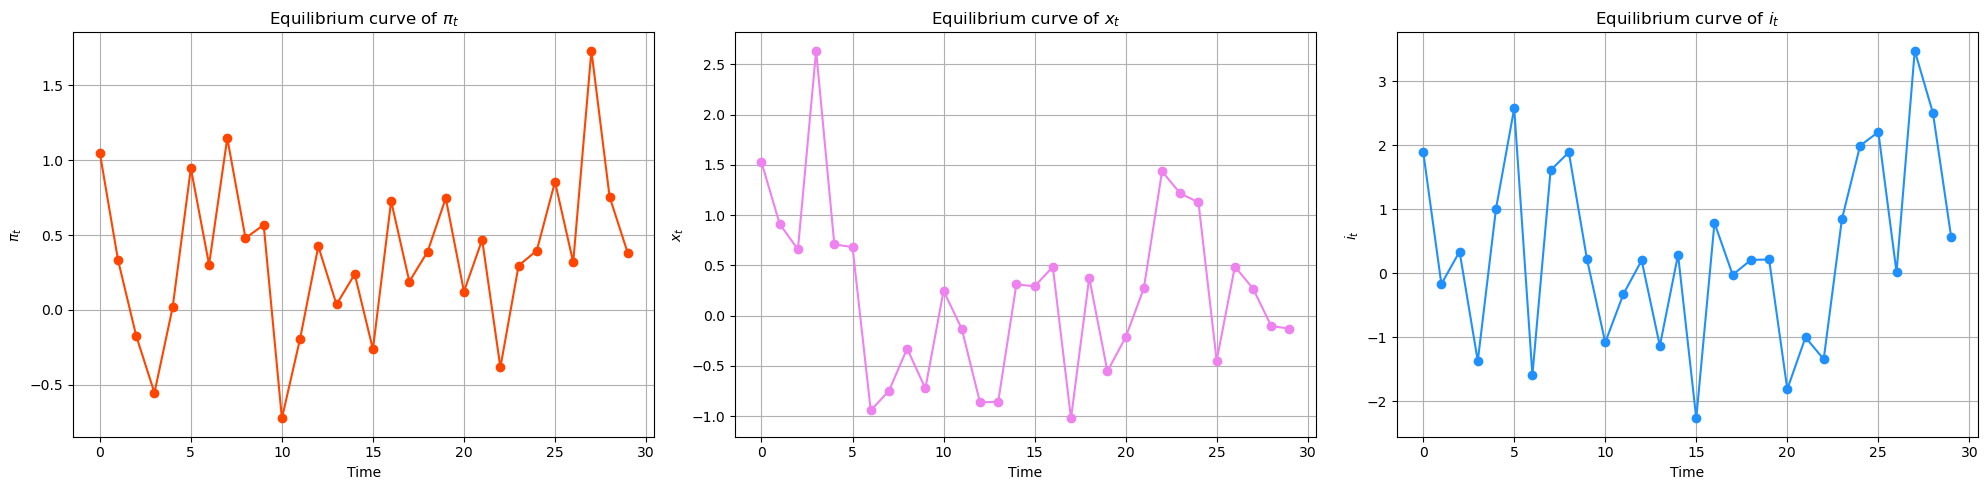

In [ ]:
T = 30      # simulate period
init_shocks = jnp.zeros(3, dtype=jnp.float32)       # set initial shocks to zero
series = get_simulated_series(model, P, T, init_shocks)     # Simulate path over time

fig, axes = plt.subplots(1, 3, figsize=(20, 5))     # Plot path
labels = [r'$\pi_{t}$', r'$x_{t}$', r'$i_{t}$']
colors = ['orangered', 'violet', 'dodgerblue']

for i in range(3):
    axes[i].plot(range(len(series)), series[:, i], marker='o', linestyle='-', color=colors[i])
    axes[i].set_title(f'Equilibrium curve of {labels[i]}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel(labels[i])
    axes[i].grid()

plt.tight_layout()
plt.show()

### Q2

In [ ]:
def get_changed_series(model, P, index, std_change=1.0, shock_t=0, periods=30):
    '''
    Simulate the path of economic parameters from the model with a specific shock.

    Args:
        model: The monetary model to simulate.
        P: The transition matrix.
        index: The index of the shock to change.
        std_change: The standard deviation change for the shock.
        periods: The number of time steps to simulate.
        shock_t: The time step to apply the shock.

    Returns:
        A tuple containing the simulated shock series and measurement series.
    '''

    t = shock_t      # Time step to apply the shock
    T = periods      # Number of periods

    shock_index = index    
    std_dev_change = std_change
    changed_shock = jnp.zeros(3, dtype=jnp.float32).at[shock_index].set(std_dev_change)
    shocks = jnp.zeros((T, 3), dtype=jnp.float32).at[t].set(changed_shock)  

    # Simulate for T periods
    shock_series = []
    measurement_series = []
    init_shock = jnp.zeros(3, dtype=jnp.float32)
    #series = get_simulated_series(model, P, T, init_shock) 
    prev_shock = init_shock

    for t in range(T):
        current_shock = model.transition(prev_shock, shock_override=shocks[t])
        measurement = model.measurement(P, current_shock)
        shock_series.append(current_shock)
        measurement_series.append(measurement)
        prev_shock = current_shock

    shock_series = jnp.array(shock_series)
    measurement_series = jnp.array(measurement_series)

    return shock_series, measurement_series

In [ ]:
indexs = [0, 1, 2]   # 0 : u, 1 : r, 2 : nu.
names = ['u', 'r', 'nu']

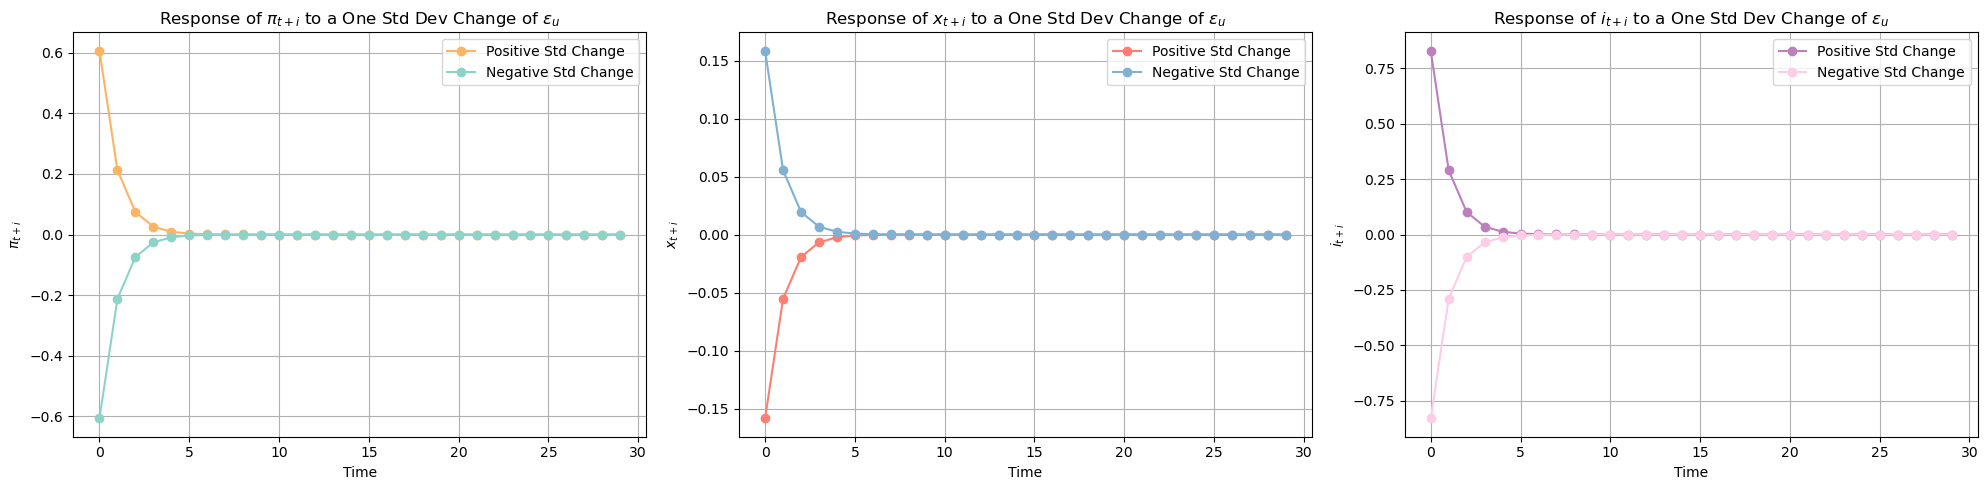

<Figure size 640x480 with 0 Axes>

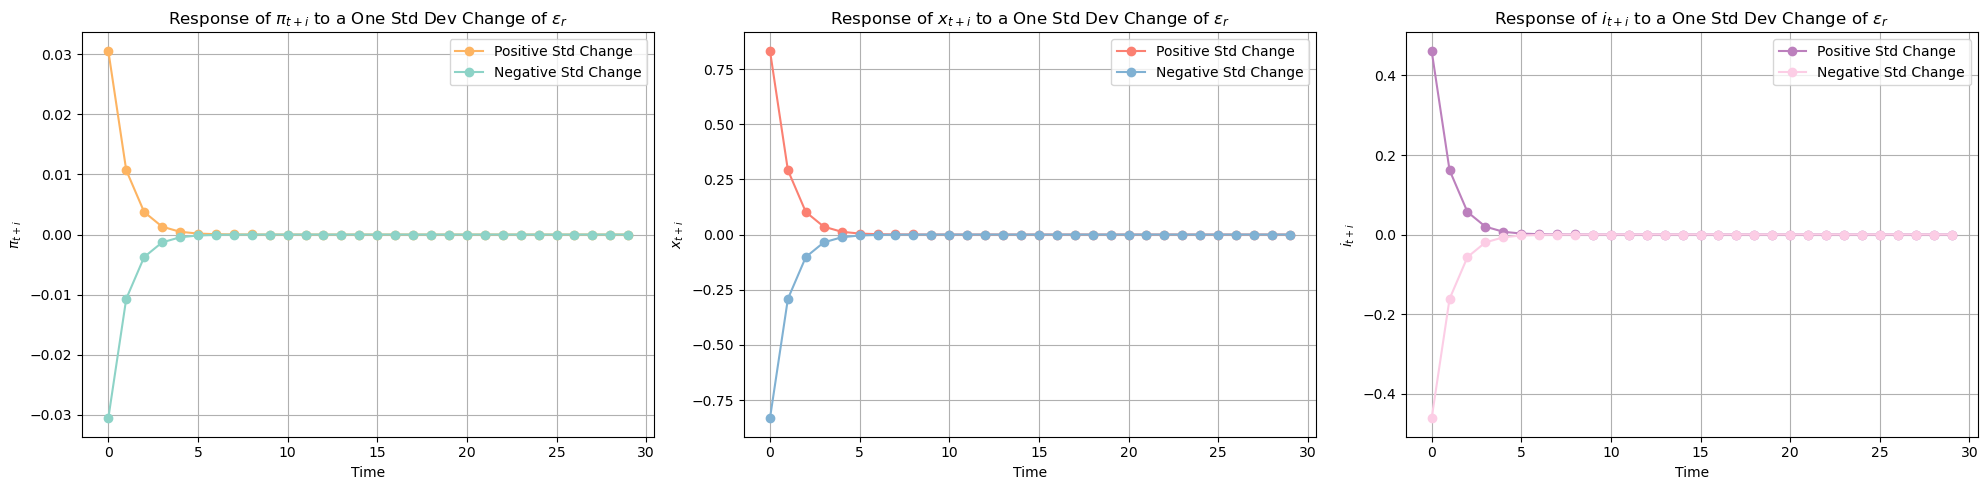

<Figure size 640x480 with 0 Axes>

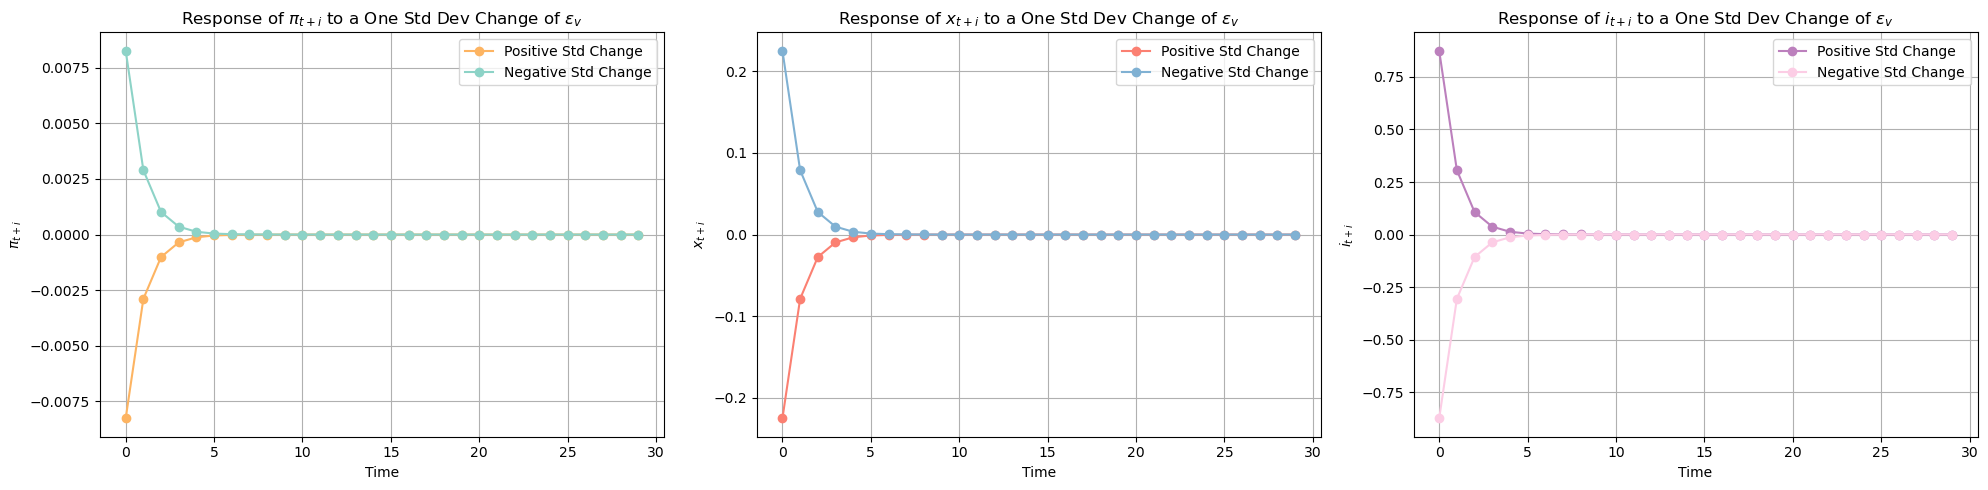

<Figure size 640x480 with 0 Axes>

In [ ]:
for index in indexs:
    P = model.solve_P()    
    shock_series_posi, measurement_series_posi = get_changed_series(model, P, index, std_change=1.0)
    shock_series_nega, measurement_series_nega = get_changed_series(model, P, index, std_change=-1.0)
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    labels = [r'$\pi_{t+i}$', r'$x_{t+i}$', r'$i_{t+i}$']
    shocks_name = [r'$ε_{u}$', r'$ε_{r}$', r'$ε_{v}$']

    color_name = 'Set3' 
    select1 = (0.45,0.3,0.8)
    colors_1 = plt.get_cmap(color_name)(select1)
    select2 = (0.05,0.35,0.60)
    colors_2 = plt.get_cmap(color_name)(select2)

    for i in range(3):
        axes[i].plot(range(len(measurement_series_posi)), measurement_series_posi[:, i], marker='o', linestyle='-', color=colors_1[i], label='Positive Std Change')
        axes[i].plot(range(len(measurement_series_nega)), measurement_series_nega[:, i], marker='o', linestyle='-', color=colors_2[i] , label='Negative Std Change')
        axes[i].set_title(f'Response of {labels[i]} to a One Std Dev Change of {shocks_name[index]}')
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel(labels[i])
        axes[i].grid()
        axes[i].legend(loc='upper right')

    plt.tight_layout()
    plt.savefig(os.path.join(result_dir, f'response_{names[index]}.png'), dpi=300)
    plt.show()

### Q3

#### kappa change

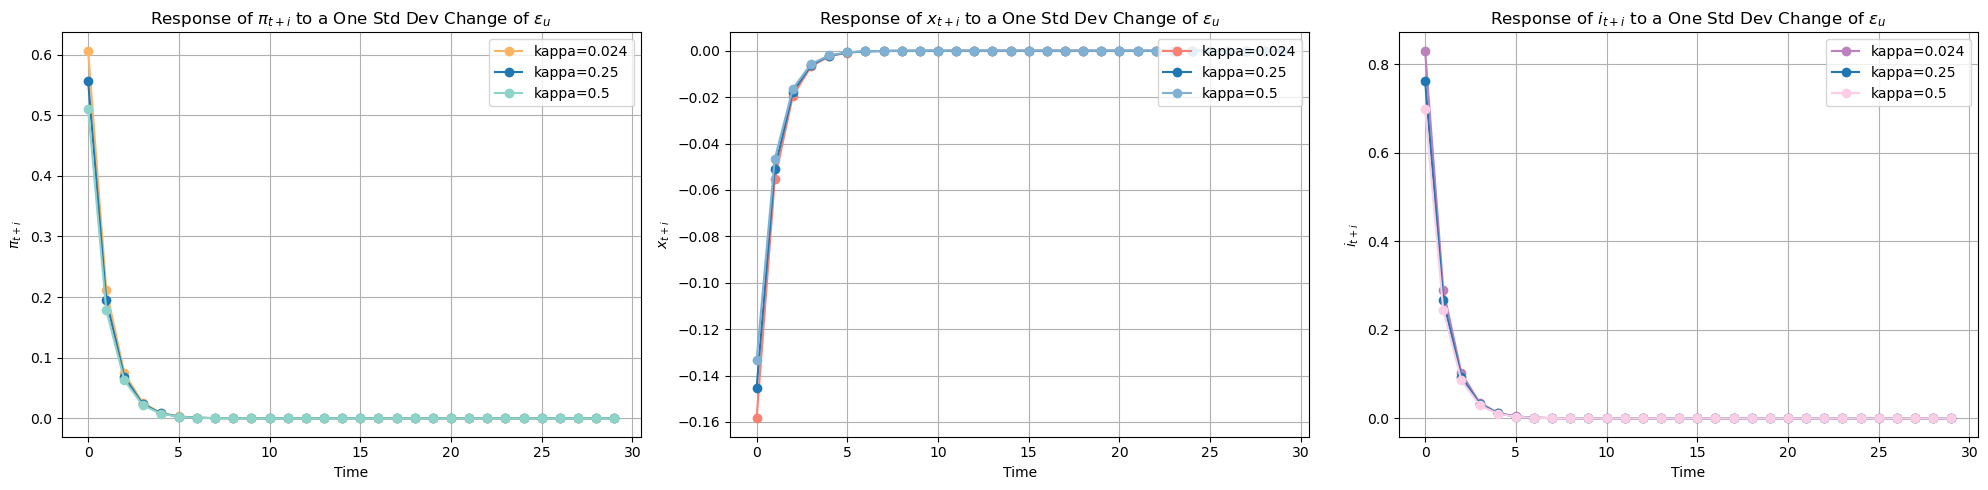

<Figure size 640x480 with 0 Axes>

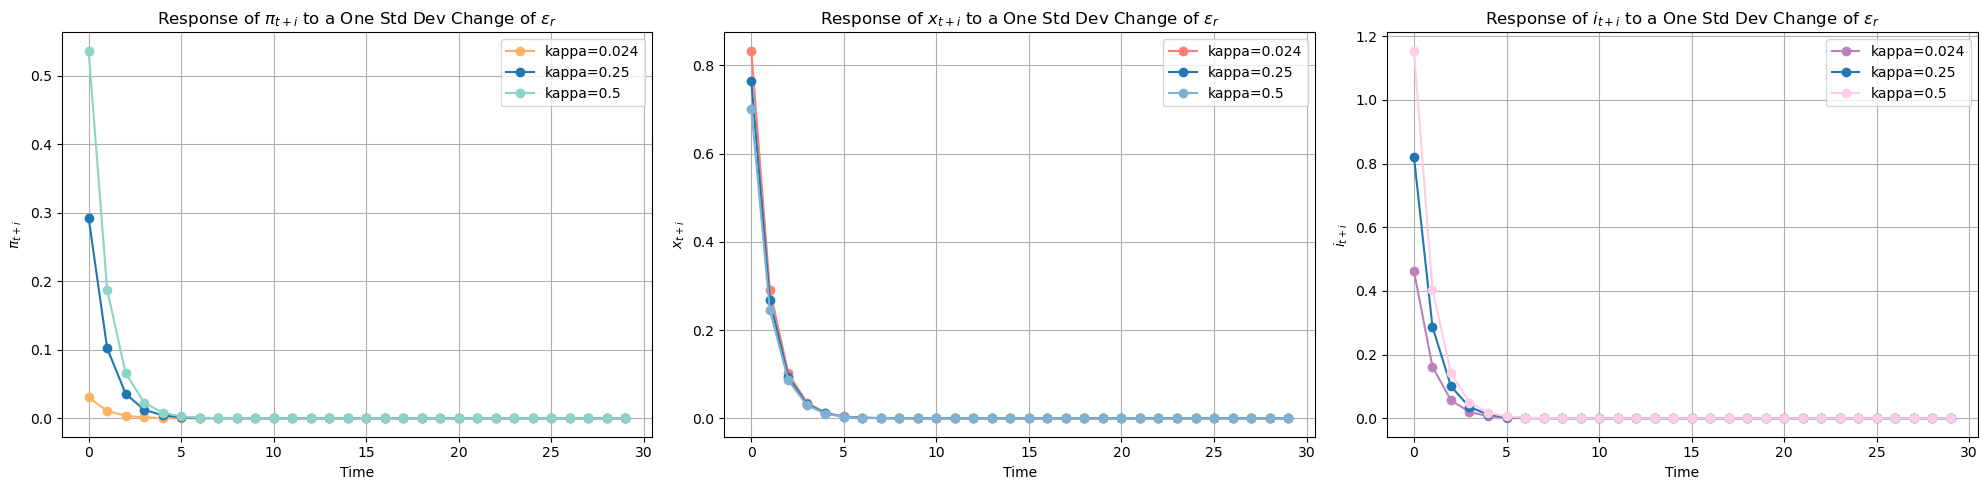

<Figure size 640x480 with 0 Axes>

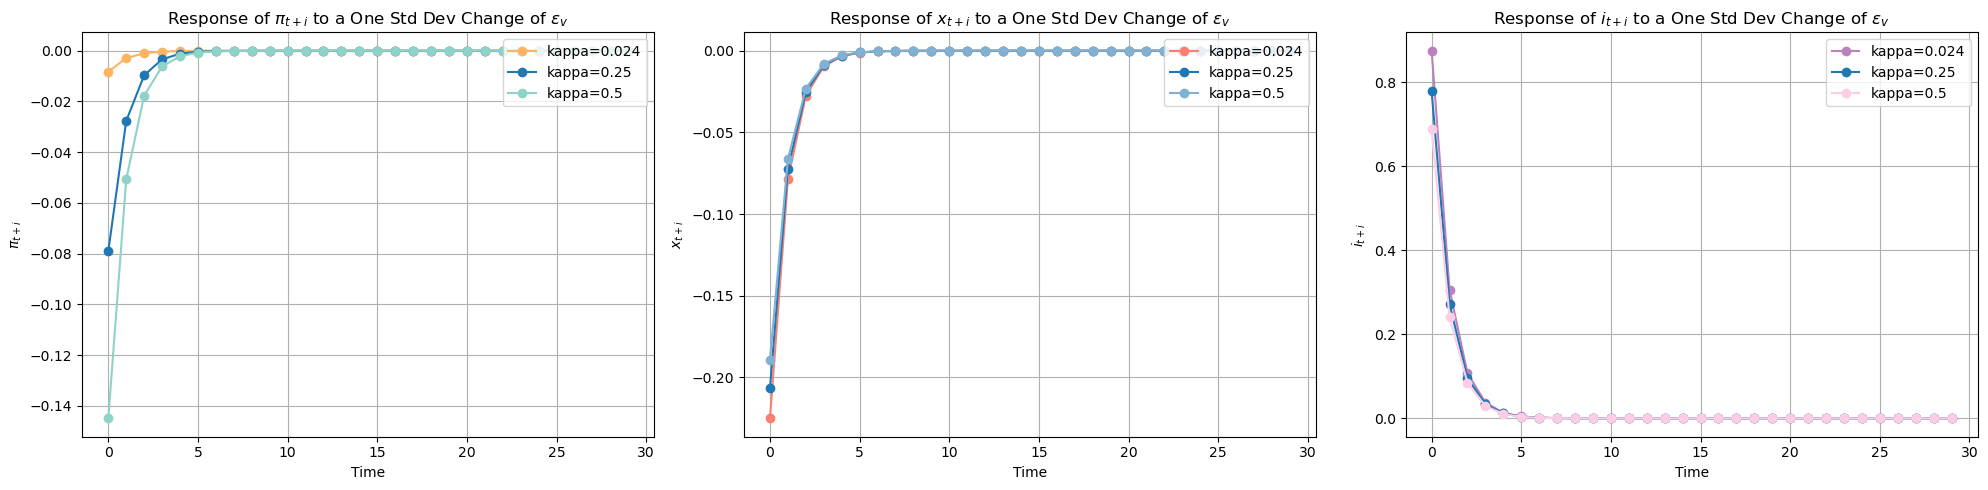

<Figure size 640x480 with 0 Axes>

In [ ]:
for index in indexs:
    P1 = model.solve_P()    
    shock_series, measurement_series = get_changed_series(model, P1, index)

    P2 = model.solve_P(kappa=0.25)    
    changed_shock_series, changed_measurement_series_1 = get_changed_series(model, P2, index)

    P3 = model.solve_P(kappa=0.5)    
    changed_shock_series, changed_measurement_series_2 = get_changed_series(model, P3, index)
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    labels = [r'$\pi_{t+i}$', r'$x_{t+i}$', r'$i_{t+i}$']
    shocks_name = [r'$ε_{u}$', r'$ε_{r}$', r'$ε_{v}$']

    color_name = 'Set3' 
    select1 = (0.45,0.3,0.8)
    colors_1 = plt.get_cmap(color_name)(select1)
    select2 = (0.05,0.35,0.60)
    colors_2 = plt.get_cmap(color_name)(select2)

    for i in range(3):
        axes[i].plot(range(len(measurement_series)), measurement_series[:, i], marker='o', linestyle='-', color=colors_1[i], label='kappa=0.024')
        axes[i].plot(range(len(changed_measurement_series_1)), changed_measurement_series_1[:, i], marker='o', linestyle='-', label='kappa=0.25')
        axes[i].plot(range(len(changed_measurement_series_2)), changed_measurement_series_2[:, i], marker='o', linestyle='-', color=colors_2[i], label='kappa=0.5')
        axes[i].set_title(f'Response of {labels[i]} to a One Std Dev Change of {shocks_name[index]}')
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel(labels[i])
        axes[i].grid()
        axes[i].legend(loc='upper right')

    plt.tight_layout()
    plt.savefig(os.path.join(result_dir, f'response_{names[index]}_kappa.png'), dpi=300)
    plt.show()

#### phi_pi and phi_x change

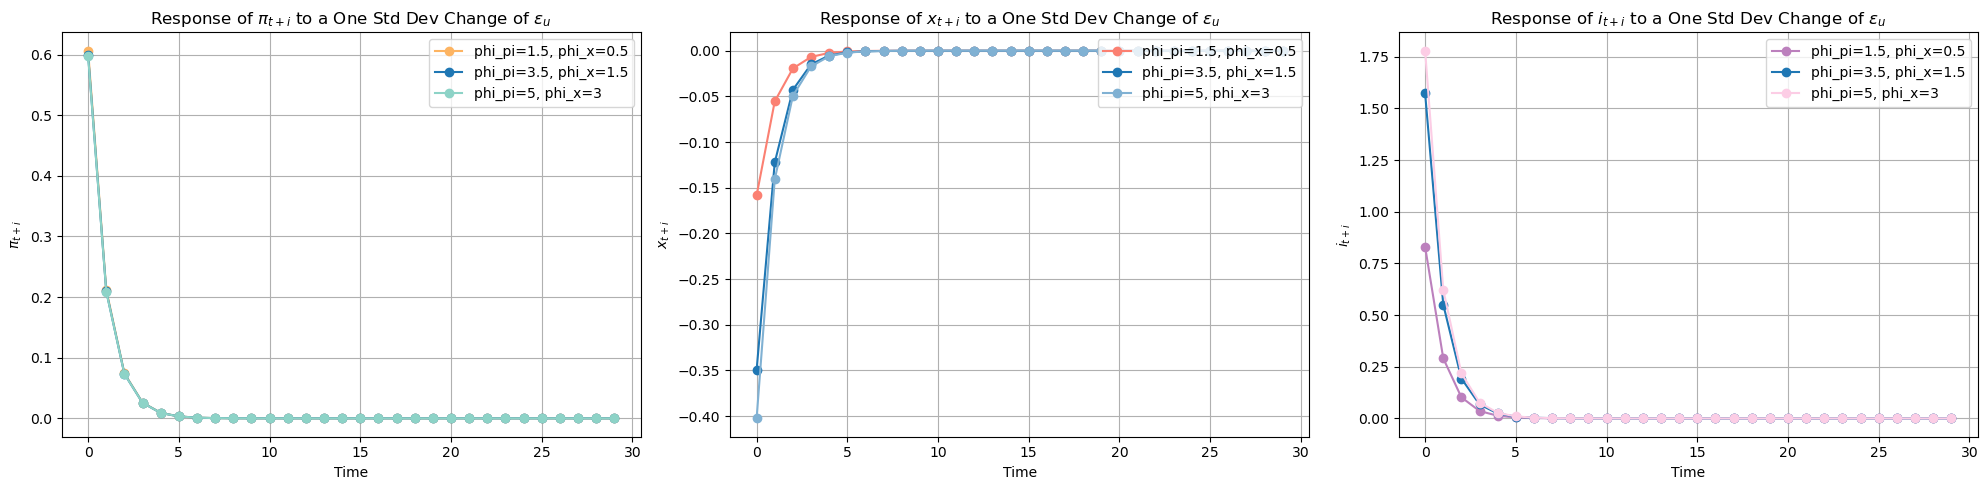

<Figure size 640x480 with 0 Axes>

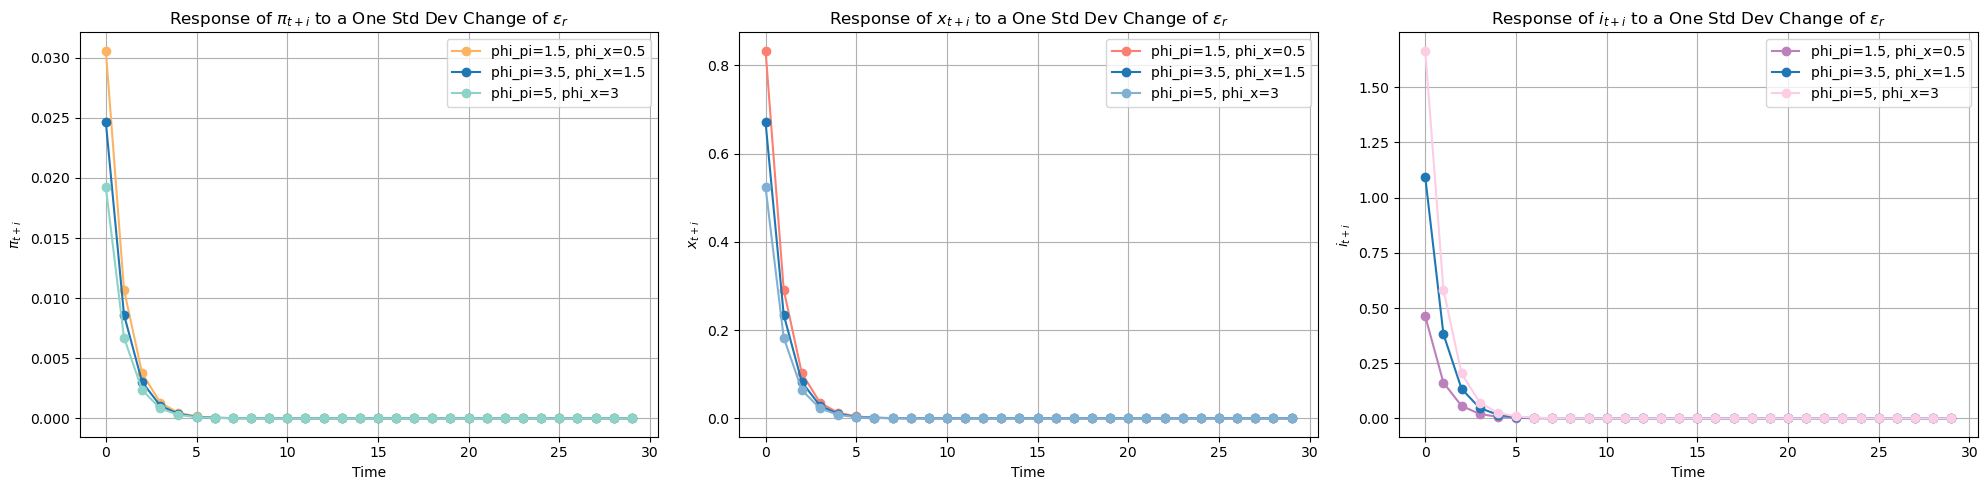

<Figure size 640x480 with 0 Axes>

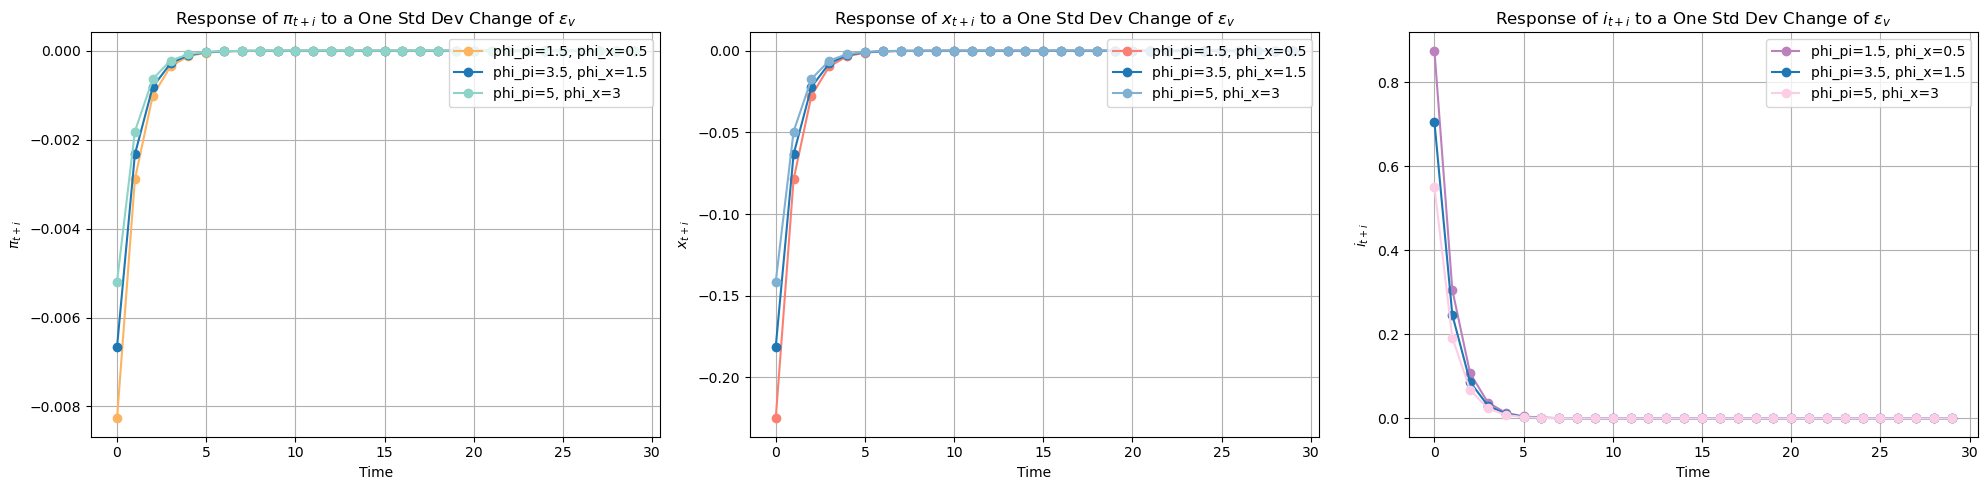

<Figure size 640x480 with 0 Axes>

In [ ]:
for index in indexs:
    P1 = model.solve_P()    
    shock_series, measurement_series = get_changed_series(model, P1, index)

    P2 = model.solve_P(phi_pi=3.5, phi_x=1.5)
    changed_shock_series, changed_measurement_series_1 = get_changed_series(model, P2, index)

    P3 = model.solve_P(phi_pi=5, phi_x=3)
    changed_shock_series, changed_measurement_series_2 = get_changed_series(model, P3, index)
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    labels = [r'$\pi_{t+i}$', r'$x_{t+i}$', r'$i_{t+i}$']
    shocks_name = [r'$ε_{u}$', r'$ε_{r}$', r'$ε_{v}$']

    color_name = 'Set3' 
    select1 = (0.45,0.3,0.8)
    colors_1 = plt.get_cmap(color_name)(select1)
    select2 = (0.05,0.35,0.60)
    colors_2 = plt.get_cmap(color_name)(select2)

    for i in range(3):
        axes[i].plot(range(len(measurement_series)), measurement_series[:, i], marker='o', linestyle='-', color=colors_1[i], label='phi_pi=1.5, phi_x=0.5')
        axes[i].plot(range(len(changed_measurement_series_1)), changed_measurement_series_1[:, i], marker='o', linestyle='-', label='phi_pi=3.5, phi_x=1.5')
        axes[i].plot(range(len(changed_measurement_series_2)), changed_measurement_series_2[:, i], marker='o', linestyle='-', color=colors_2[i], label='phi_pi=5, phi_x=3')
        axes[i].set_title(f'Response of {labels[i]} to a One Std Dev Change of {shocks_name[index]}')
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel(labels[i])
        axes[i].grid()
        axes[i].legend(loc='upper right')

    plt.tight_layout()
    plt.savefig(os.path.join(result_dir, f'response_{names[index]}_phi.png'), dpi=300)
    plt.show() 

In [ ]:
def get_RhoChanged_series(model, P, index, rho_r, rho_u, std_change=1.0, shock_t=0, periods=30):
    '''
    Simulate the path of economic parameters from the model with a specific shock and rho_r/rho_u change.

    Args:
        model: The monetary model to simulate.
        P: The transition matrix.
        index: The index of the shock to change.
        rho_r: The rho_r parameter for the model.
        rho_u: The rho_u parameter for the model.
        std_change: The standard deviation change for the shock.
        periods: The number of time steps to simulate.
        shock_t: The time step to apply the shock.
    
    Returns:    
        A tuple containing the simulated shock series and measurement series.
    '''

    t = shock_t     # Time step to apply the shock
    T = periods      # Number of periods

    shock_index = index    
    std_dev_change = std_change
    changed_shock = jnp.zeros(3, dtype=jnp.float32).at[shock_index].set(std_dev_change)
    shocks = jnp.zeros((T, 3), dtype=jnp.float32).at[t].set(changed_shock)  

    # Simulate for T periods
    shock_series = []
    measurement_series = []
    init_shock = jnp.zeros(3, dtype=jnp.float32)
    #series = get_simulated_series(model, P, T, init_shock) 
    prev_shock = init_shock

    for t in range(T):
        current_shock = model.transition(prev_shock, shock_override=shocks[t],rho_r=rho_r, rho_u=rho_u)
        measurement = model.measurement(P, current_shock)
        shock_series.append(current_shock)
        measurement_series.append(measurement)
        prev_shock = current_shock

    shock_series = jnp.array(shock_series)
    measurement_series = jnp.array(measurement_series)

    return shock_series, measurement_series

#### rho_r and rho_u change

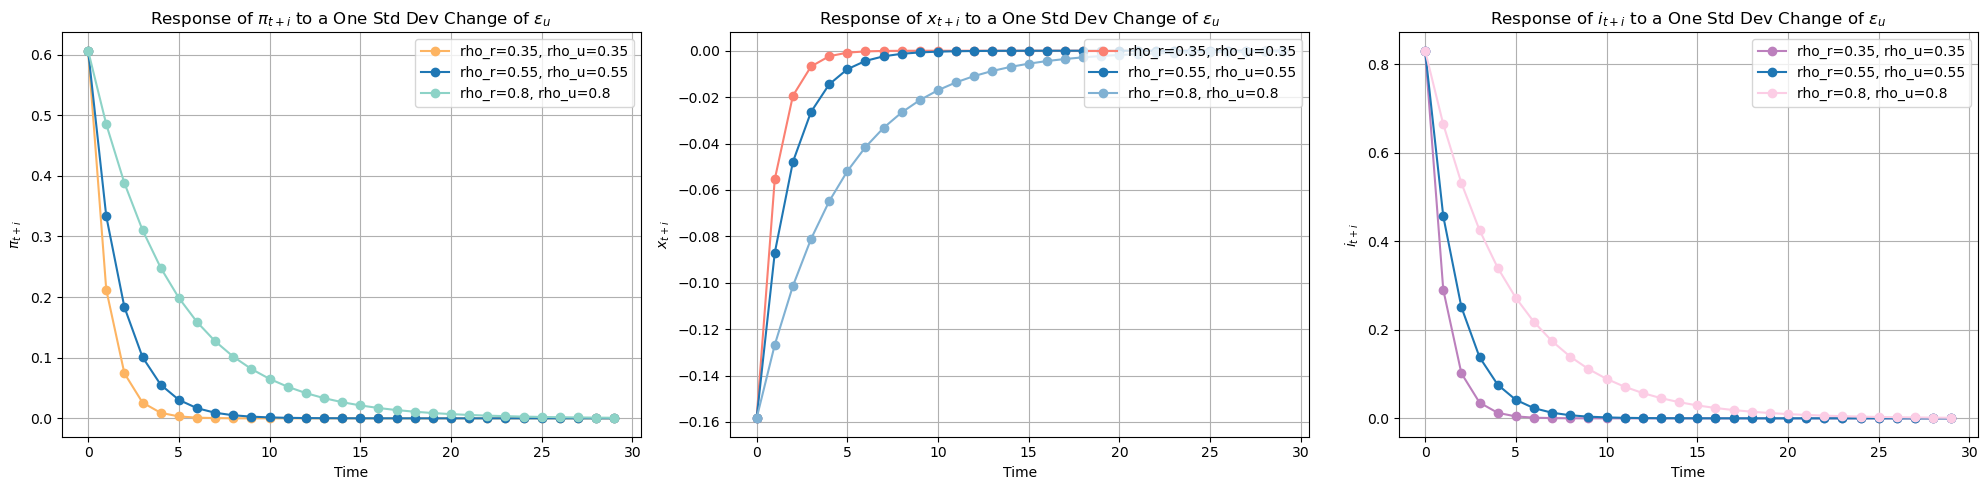

<Figure size 640x480 with 0 Axes>

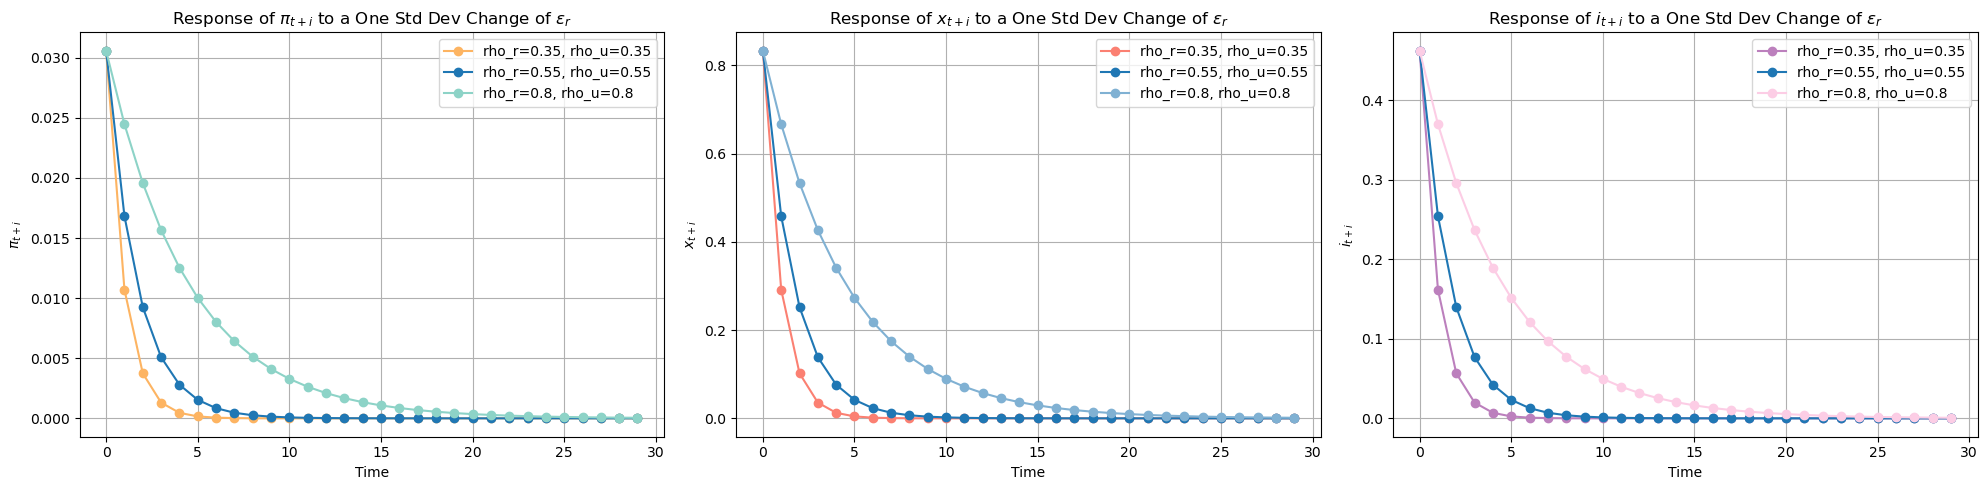

<Figure size 640x480 with 0 Axes>

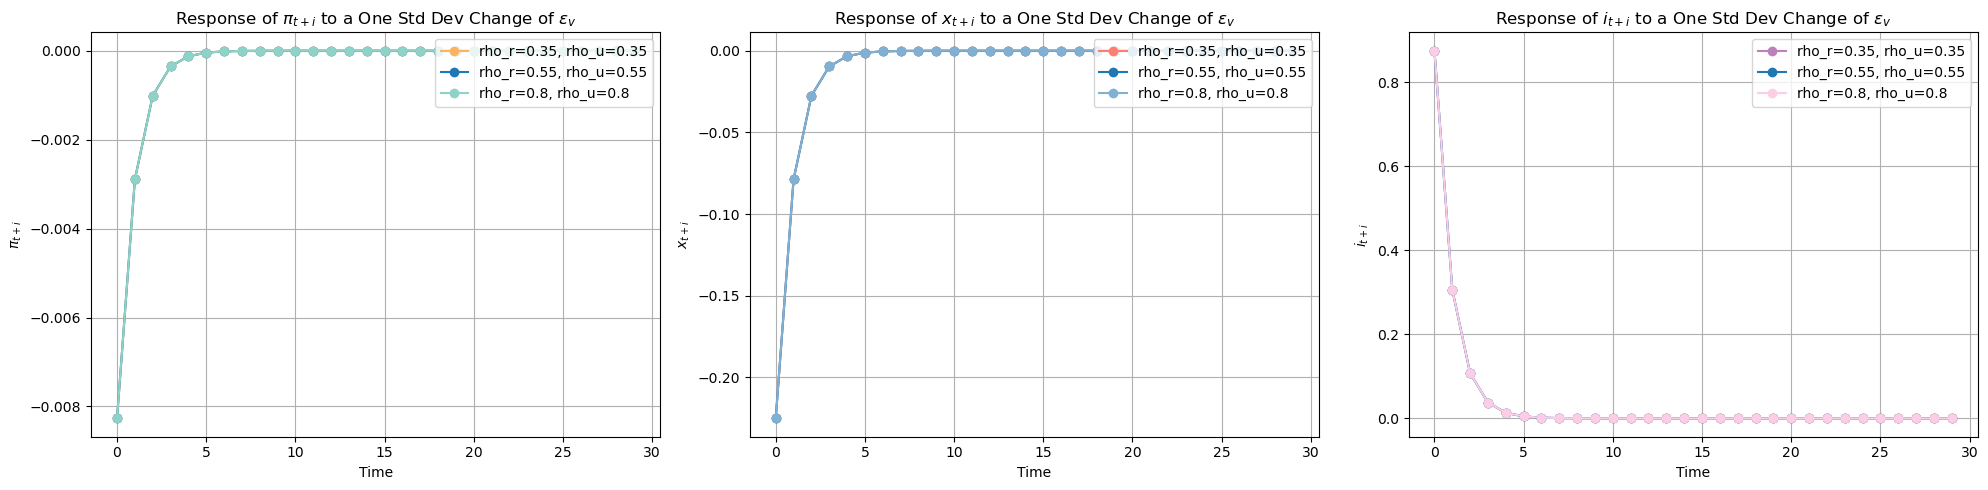

<Figure size 640x480 with 0 Axes>

In [ ]:
for index in indexs:
    P = model.solve_P()    
    shock_series, measurement_series = get_changed_series(model, P, index)

    changed_shock_series, changed_measurement_series_1 = get_RhoChanged_series(model, P, index, rho_r=0.55, rho_u=0.55)

    changed_shock_series, changed_measurement_series_2 = get_RhoChanged_series(model, P, index, rho_r=0.8, rho_u=0.8)
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    labels = [r'$\pi_{t+i}$', r'$x_{t+i}$', r'$i_{t+i}$']
    shocks_name = [r'$ε_{u}$', r'$ε_{r}$', r'$ε_{v}$']

    color_name = 'Set3' 
    select1 = (0.45,0.3,0.8)
    colors_1 = plt.get_cmap(color_name)(select1)
    select2 = (0.05,0.35,0.60)
    colors_2 = plt.get_cmap(color_name)(select2)

    for i in range(3):
        axes[i].plot(range(len(measurement_series)), measurement_series[:, i], marker='o', linestyle='-', color=colors_1[i], label='rho_r=0.35, rho_u=0.35')
        axes[i].plot(range(len(changed_measurement_series_1)), changed_measurement_series_1[:, i], marker='o', linestyle='-', label='rho_r=0.55, rho_u=0.55')
        axes[i].plot(range(len(changed_measurement_series_2)), changed_measurement_series_2[:, i], marker='o', linestyle='-', color=colors_2[i], label='rho_r=0.8, rho_u=0.8')
        axes[i].set_title(f'Response of {labels[i]} to a One Std Dev Change of {shocks_name[index]}')
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel(labels[i])
        axes[i].grid()
        axes[i].legend(loc='upper right')

    plt.tight_layout()
    plt.savefig(os.path.join(result_dir, f'response_{names[index]}_rho.png'), dpi=300)
    plt.show()